## Demo notebook to train a graph convolutional network

In [1]:
import time
import os

import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.loader import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

from cancernet.arch import GCNNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet

/ext3/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
dataset = PnetDataSet(
    root=os.path.join("../data", "prostate"),
    name="prostate_graph_humanbase",
    # files={'graph_file': "global.geneSymbol.gz"},
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    ),
)

/ext3/miniconda3/lib/python3.11/site-packages/torch_geometric/data/dataset.py:214: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, make sure to delete '../data/prostate' first
  warnings.warn(
/ext3/miniconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Import train/valid/test splits from P-NET

In [3]:
splits_root = os.path.join("../data", "prostate", "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)

/ext3/miniconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


## Train

Set up hyperparameters and random seed, and initialise dataloaders

In [6]:
# Set random seed
pl.seed_everything(42, workers=True)

## Optimised hyperparameters from https://wandb.ai/cancer-net/hyperparam_sweeps_May/sweeps/u6dqzdbo
n_epochs = 100
batch_size = 10
graph_dims=32
mlp_dims=256
layers=2
lr=0.0212


train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
)

[rank: 0] Global seed set to 42


Train.

In [7]:
t0 = time.time()

model = GCNNet(graph_dims=graph_dims,mlp_dims=mlp_dims,layers=layers,lr=lr)
logger = InMemoryLogger()

trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=n_epochs,
    callbacks=[ProgressBar()],
    logger=logger
)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | graphs | ModuleList | 1.2 K 
1 | fc1    | Linear     | 8.4 K 
2 | fc2    | Linear     | 514   
3 | m      | LogSoftmax | 0     
--------------------------------------
10.1 K    Trainable params
0         Non-trainable params
10.1 K    Total params
0.041     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
/ext3/minicond

Training took 83.2 seconds.


Visualize training trajectory.

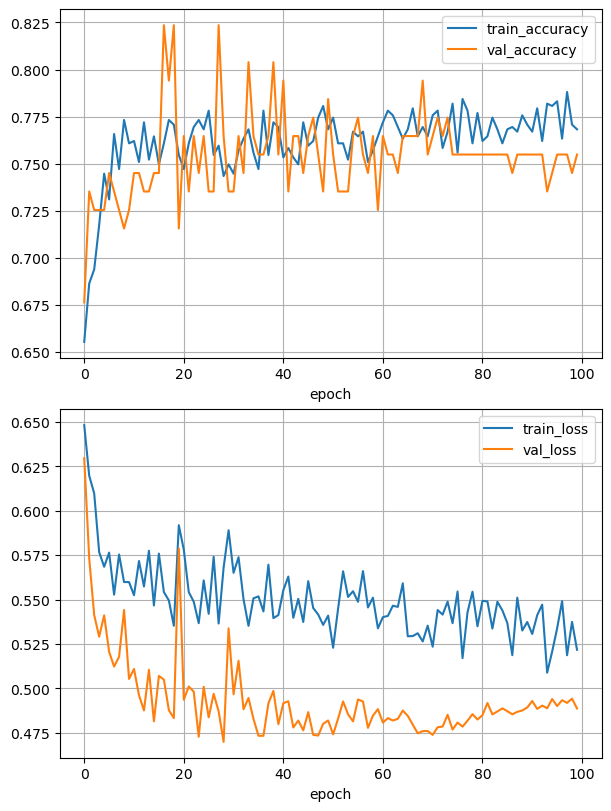

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
ax1.grid()

logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
ax2.grid()

Calculate and show ROC and AUC.

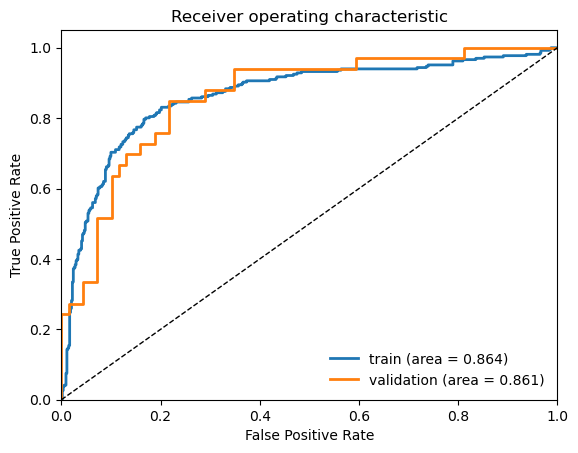

In [9]:
fpr_train, tpr_train, train_auc, _, _ = get_roc(model, train_loader)
fpr_valid, tpr_valid, valid_auc, _, _ = get_roc(model, valid_loader)

fig, ax = plt.subplots()
ax.plot(fpr_train, tpr_train, lw=2, label="train (area = %0.3f)" % train_auc)
ax.plot(fpr_valid, tpr_valid, lw=2, label="validation (area = %0.3f)" % valid_auc)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.05)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)

Check performance on test set.

In [10]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=True,
)
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader)

print("accuracy", accuracy_score(ys, outs[:, 1] > 0.5))
print("auc", test_auc)
print("aupr", average_precision_score(ys, outs[:, 1]))
print("f1", f1_score(ys, outs[:, 1] > 0.5))
print("precision", precision_score(ys, outs[:, 1] > 0.5))
print("recall", recall_score(ys, outs[:, 1] > 0.5))

accuracy 0.79
auc 0.9072817729534148
aupr 0.8155034631113411
f1 0.5531914893617021
precision 0.9285714285714286
recall 0.3939393939393939
